In [1]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
#%matplotlib widget
#%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from progressbar import ProgressBar
import torch
import torch.nn as nn
import torch.nn.functional as F
from img_utils import *

fg_path = './models/Batch Renderding/scene/image_out/*'
#label_path='./models/Batch Renderding/scene/label_out/*'
bg_path = '/run/media/d0048/DATA/data/imagenet/raw/val_nodir/*'

 10% (1 of 10) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00

Loading forgrounds from ./models/Batch Renderding/renders/scene_without_numbers/image_out/*:


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


10 pairs of foreground loaded.
Resolution:  [270, 240]
57 backgrounds found. 


/usr/local/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


## Augmentation

### Augmentor

In [ ]:
import Augmentor
p = Augmentor.Pipeline(fg_path.replace('*',''))
p.ground_truth(fg_path.replace('*','').replace('image','label'))
p.rotate(probability = 1, max_left_rotation =5, max_right_rotation =5)
p.flip_left_right(probability = 0.5)
p.flip_top_bottom(probability = 0.3)
p.sample(10)

In [ ]:
batch_size = 6
g = p.keras_generator(batch_size=batch_size)

X, y = next(g)
print(X.shape)
print(y.shape)

### ImgAug

(1, 240, 270, 3)
(1, 240, 270, 4)
{'size': array([0.5006532 , 0.55250419, 0.60992995, 0.7700238 , 0.57863106,
       0.71338343, 0.5513174 , 0.76025769, 0.56471272, 0.70652935,
       0.58196968, 0.75243964, 0.76555797, 0.47970847, 0.52280581,
       0.51548259, 0.54262068, 0.58727304, 0.44506396, 0.46793445]), 'min_num': 1.0, 'min_area': 0.0018058014233516566}
Image shape: (240, 270, 3)
Label shape: (240, 270, 4)


<Figure size 432x288 with 0 Axes>

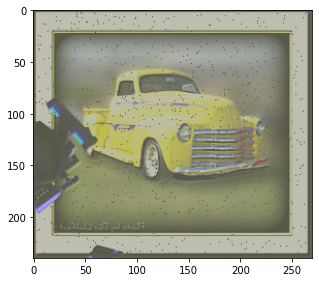

<Figure size 432x288 with 0 Axes>

In [6]:
def get_blended(plot=False, augment=True):
    bg, bg_label = get_bg_pair() # an image and an empty label of size res
    para = get_para()
    n = 0
    while area_percent(np.array(bg_label)) < para['min_area'] and n <= np.min(para['min_num']):
        # for n in range(int(para['min_num'])):
        fg, label = get_pair_PIL()
        newsize = (np.array(res)*para['size'][n %
                                              int(para['size'].shape[0])]).astype(np.int)
        fg = fg.resize(newsize)
        label = label.resize(newsize)

        loc = (np.random.randint(0, res[0]), np.random.randint(0, res[1]))
        bg.paste(fg, loc, fg)
        bg_label.paste(label, loc, label)
        n += 1

    bg,bg_label = np.array(bg),np.array(bg_label)
    #print('bg_shape',bg.shape)
    #print('bg_label_shape',bg_label.shape)
    bg = np.expand_dims(bg, axis=0)  # [:,:,:,0:3]
    bg_label = np.expand_dims(bg_label, axis=0)
    # Augmentation
    if augment:
        bg, bg_label = augment_pair(np.array(bg), np.array(bg_label))
        bg, bg_label = bg.squeeze(), bg_label.squeeze()
        #print('Agumented')
    if plot:
        print(para)
        plt.figure(figsize=(5, 5))
        plt.imshow(bg.squeeze())
        plt.imshow(bg_label.squeeze())
    return bg, bg_label

def augment_pair(fg, label):
    print(fg.shape)
    print(label.shape)
    label_i, segmaps_aug_i = seq(images=fg, segmentation_maps=label)
    return label_i, segmaps_aug_i

img, label = get_blended(plot=True, augment=True)
#img,label=augment_pair(img,label)
print('Image shape:',img.shape)
print('Label shape:',label.shape)
plt.figure()

## Inspect

### Samples

(16, 1, 240, 270)
(16, 1, 240, 270)
(16, 1, 240, 270)


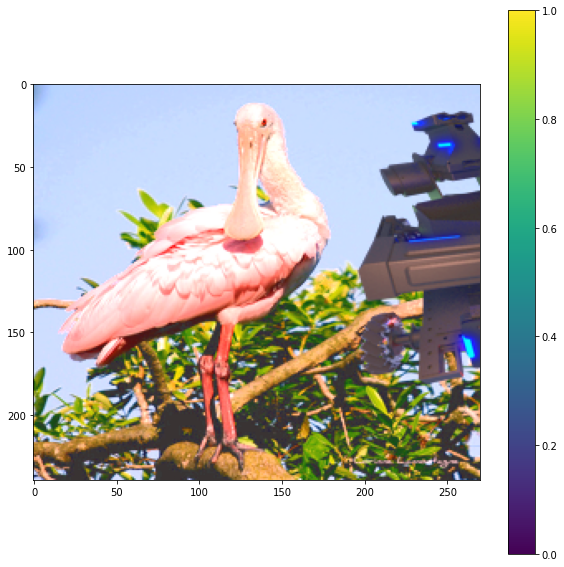

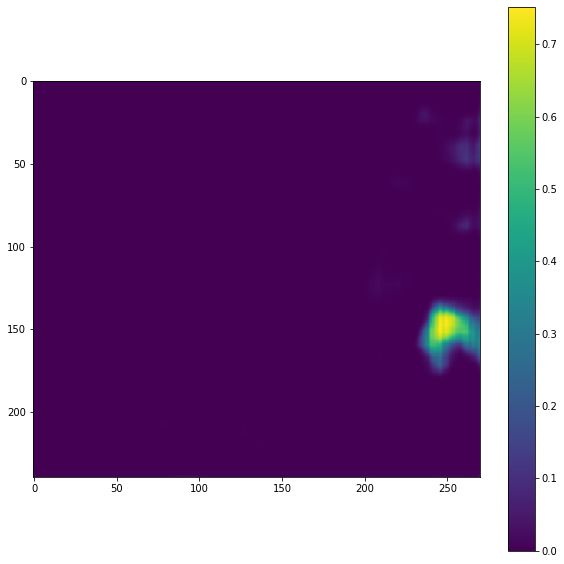

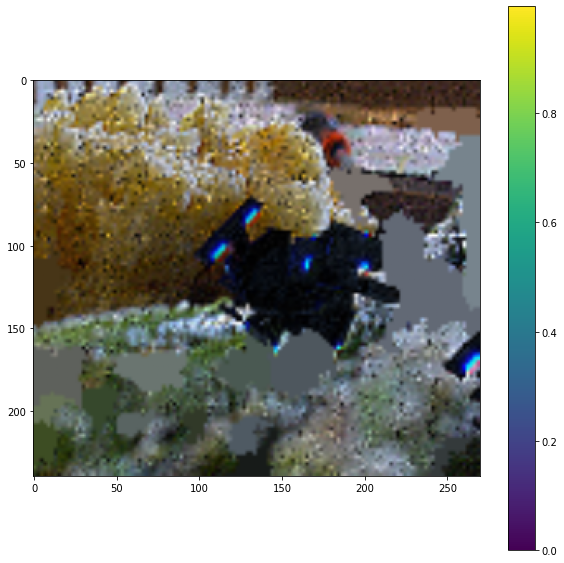

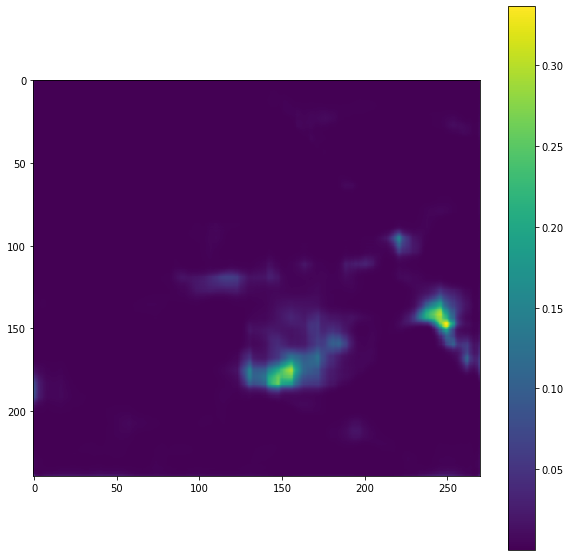

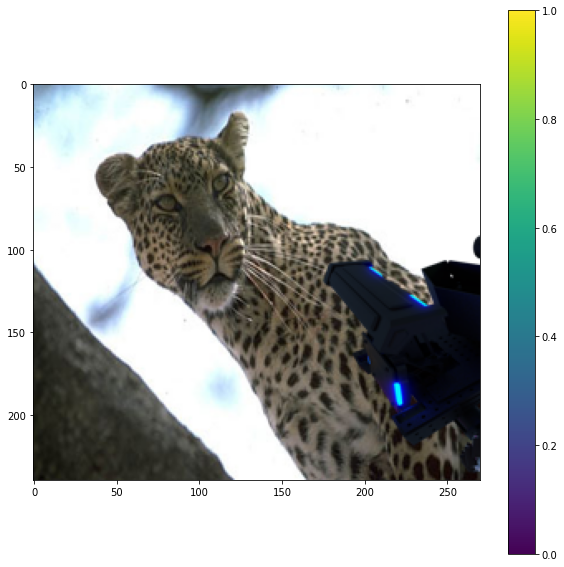

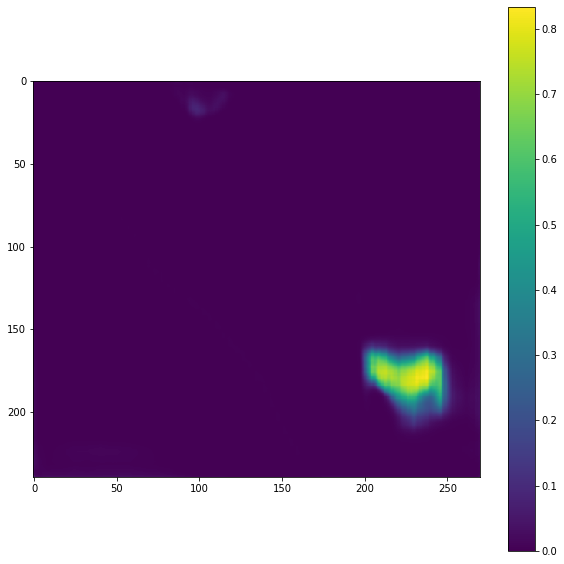

In [7]:
for idx in range(3):
    sample=np.load('./samples/sample.npz')['arr_0']
    sample_img=np.load('./samples/sample_img.npz')['arr_0'].transpose([0,2,3,1])
    sample_label=np.load('./samples/sample_label.npz')['arr_0']
    print(sample.shape)
    #sample[sample<0.5]=0
    
    plt.figure(figsize=(10, 10))
    plt.imshow(sample_img[idx]/255)
    plt.colorbar()

    plt.figure(figsize=(10, 10))
    plt.imshow(sample[idx].squeeze())
    plt.colorbar()

    #plt.figure(figsize=(10, 10))
    #plt.imshow(sample_label[idx])
    #plt.colorbar()

### Real-world

In [8]:
batch_size=1

from fcn import *
#np.random.seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # use GPU if available
device='cpu'
model=Model().to(device)
#model = nn.DataParallel(model).to(device)
print(device)

Using Naive FCN
cpu


Choosing from 6 files
torch.Size([1, 3, 240, 270])
torch.Size([1, 3, 240, 270])
torch.Size([1, 3, 240, 270])
torch.Size([1, 3, 240, 270])
torch.Size([1, 3, 240, 270])
torch.Size([1, 3, 240, 270])


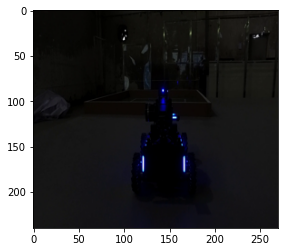

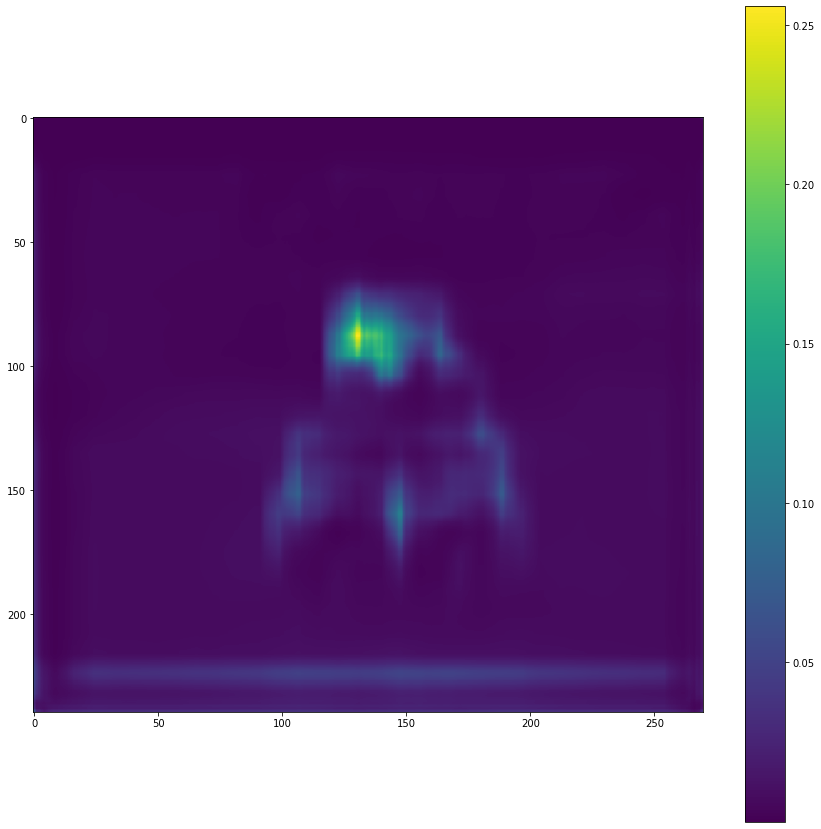

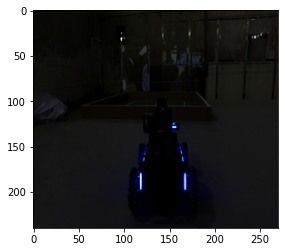

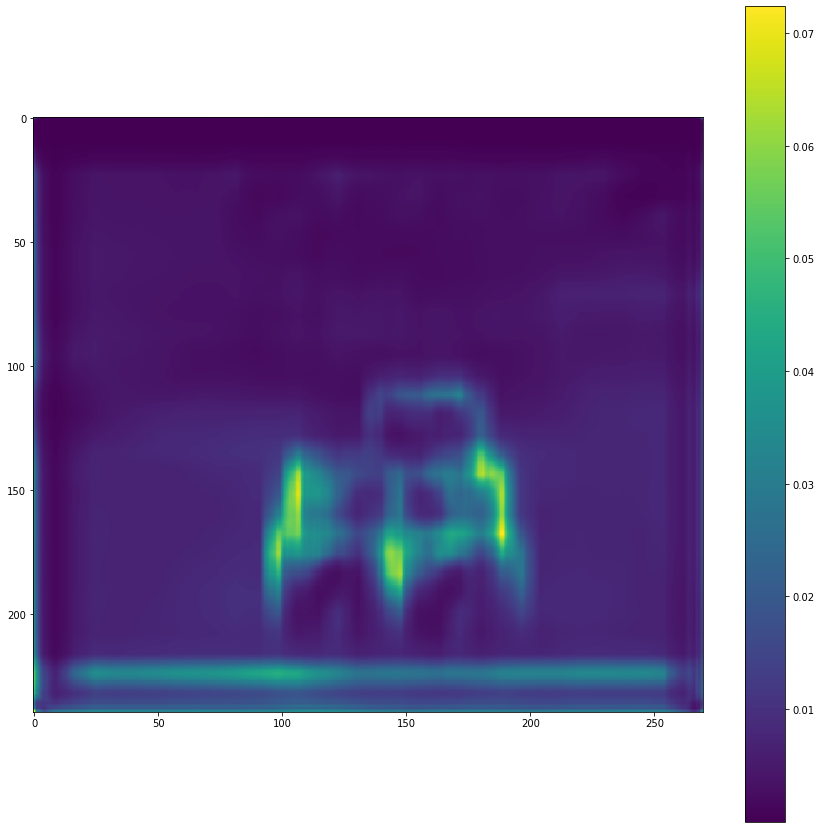

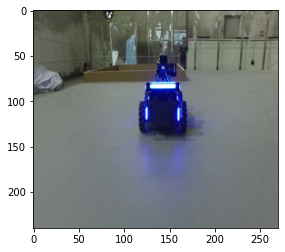

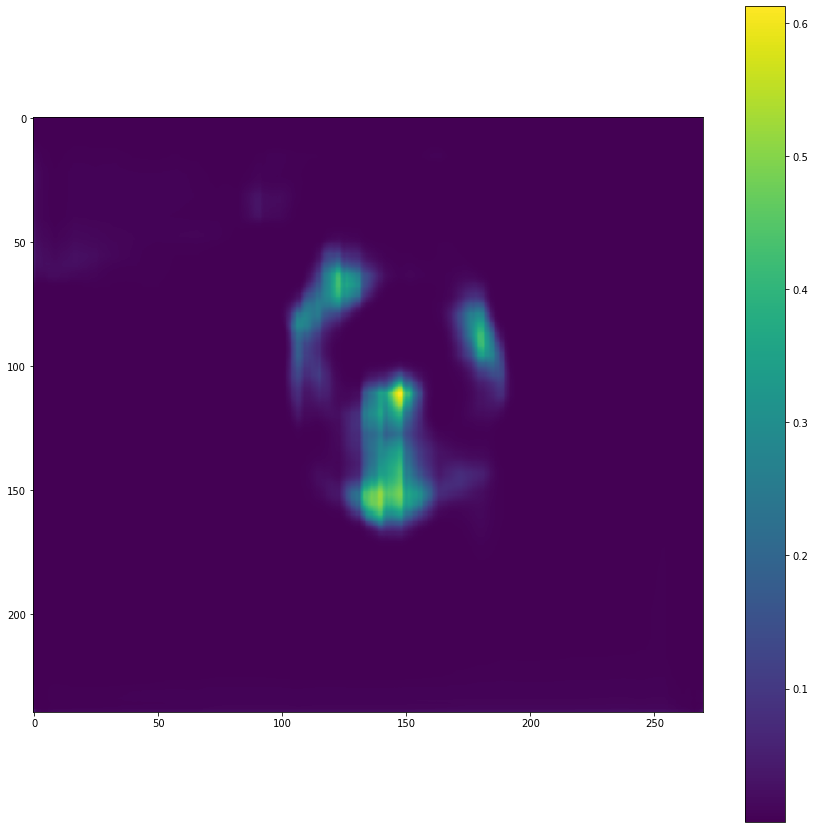

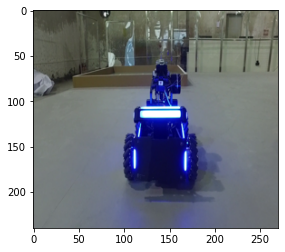

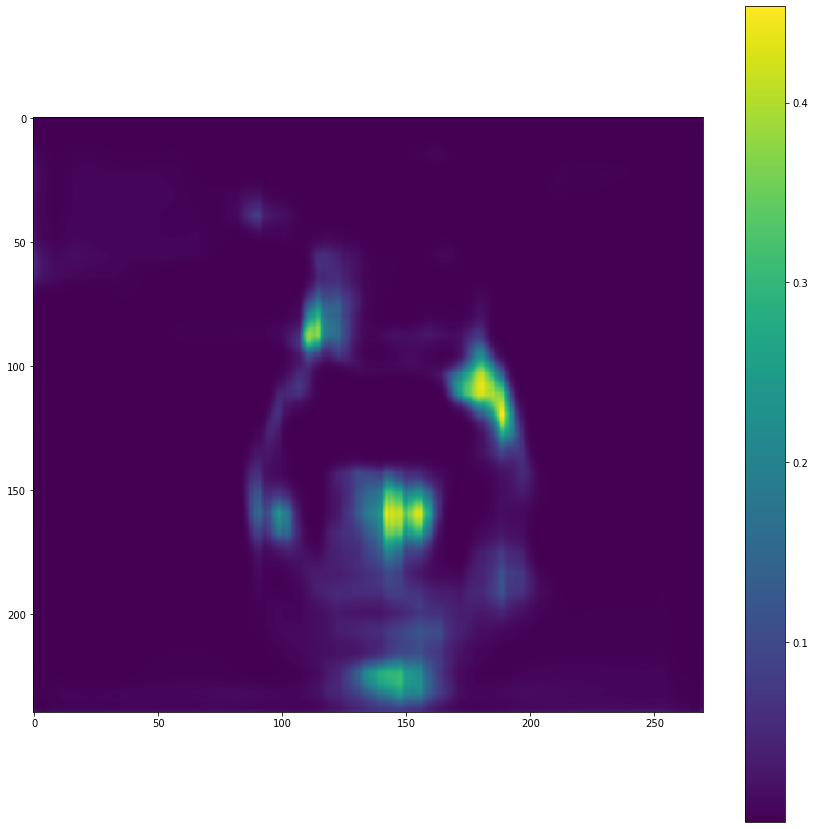

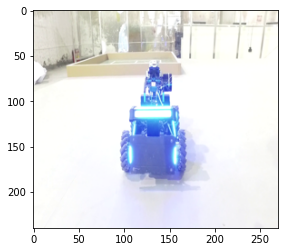

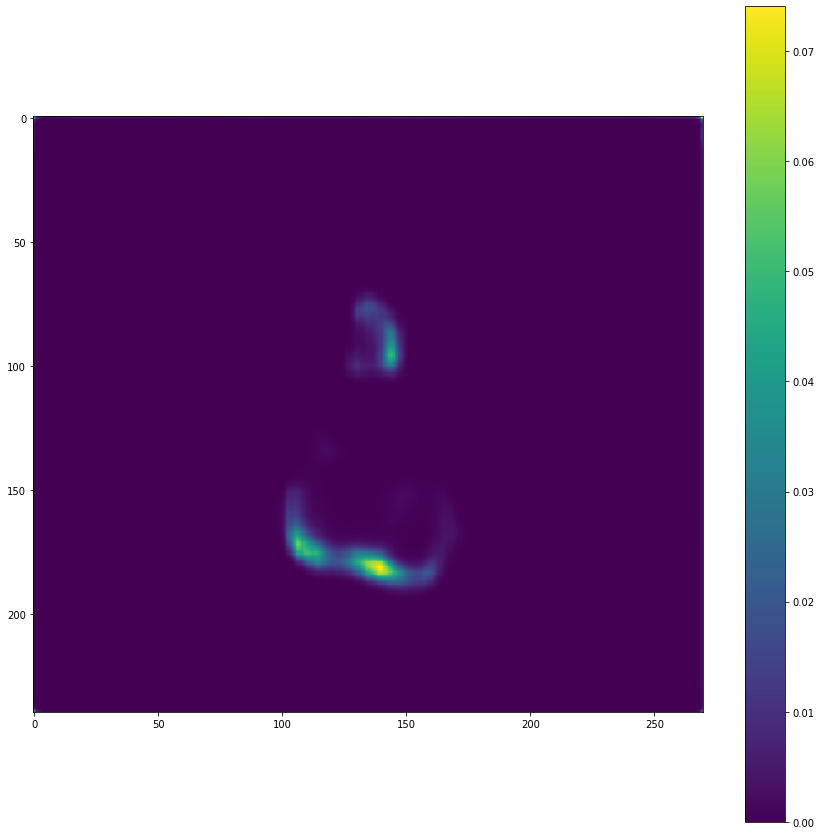

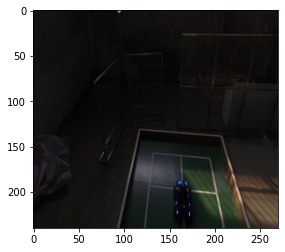

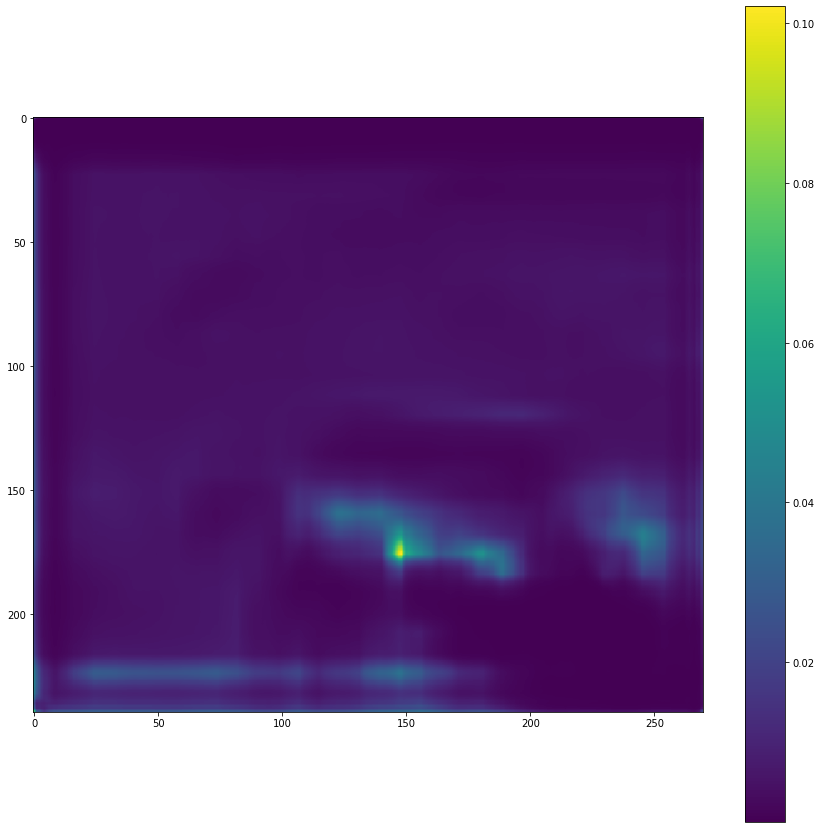

In [9]:
# original saved file with DataParallel
state_dict = torch.load('./checkpoint/model.pth')
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)

def load_real_img(paths,plot=True):
    img_batch=[]
    for path in paths:
        bg = Image.open(path)
        bg = bg.resize(res)
        img=np.array(bg)[:,:,0:4]
        #img[:, :, 0], img[:,:, 2] = img[:,:, 2], img[:, :,0].copy()

        img_batch.append(img.astype(np.float))
        if plot:
            plt.figure()
            plt.imshow(img)
    img = torch.tensor(img_batch,dtype=torch.float,device=device).permute([0,3,1,2])
    return img

torch.cuda.empty_cache()
model.eval()

files=glob.glob('/home/d0048/Program-code/IlliniRobomaster/RMSynthesis/raw/blue/*')
print('Choosing from {} files'.format(files.__len__()))
for file in files:
    img=load_real_img([file])
    print(img.shape)
    out=model(img)

    del img
    torch.cuda.empty_cache()

    see=out.detach().cpu().numpy()
    plt.figure(figsize=[15,15])
    plt.imshow(see.squeeze())
    plt.colorbar()